In [1]:
%run correlate_evolution.ipynb

%cd /work/clusterEvo/new_tests/

/work/clusterEvo/new_tests


In [2]:
import multiprocessing
import itertools
import pandas as pd
import plotly
from scipy.stats import pearsonr

In [41]:
def assess_coevolution(matrix1, matrix2, 
                       pearson=False, geneIDs=True, weighted_r2=False,
                       gene_sep='_'):
    if geneIDs:
        matrix1, taxa1, matrix2, taxa2 = balance_matrices(matrix1, matrix2, gene_sep)
    else:
        matrix1, matrix2 = balance_matrices_no_genes(matrix1.copy(), matrix2.copy())

    condensed1 = squareform(matrix1.values, checks=False)
    condensed2 = squareform(matrix2.values, checks=False)
    
    if pearson:
        return(pearsonr(condensed1,
                        condensed2))
    
    odr_weights = estimate_weights(condensed1, condensed2)
    
    regression = run_odr(condensed1, 
                         condensed2, 
                         *odr_weights)
    
    mean_x = np.mean(condensed1)
    mean_y = np.mean(condensed2)
    
    mean_pred_x = regression.xplus.mean()
    mean_pred_y = regression.y.mean()

    x_SSres = sum(regression.delta**2)
    y_SSres = sum(regression.eps  **2)
    SSres   = x_SSres + y_SSres

    SSreg = sum(
        ((regression.xplus - mean_pred_x)**2) + \
        ((regression.y     - mean_pred_y)**2)
    )
    x_SStot = sum(
        (condensed1 - mean_x)**2
    )
    y_SStot = sum(
        (condensed2 - mean_y)**2
    )
    SStot = x_SStot + y_SStot
    

    r2 = 1 - SSres/SStot
#     r2 = SSreg/SStot

#     x_mse = np.mean(regression.delta**2)
#     y_mse = np.mean(regression.eps  **2)
    mse   = x_SSres + y_SSres
#     mse   = (x_SSres/x_SStot) + (y_SSres/y_SStot)

    return(regression, r2, mse)

In [42]:
datasets = {}
for n in range(1, 11):
    print(n)
    with cd(f'set{n}/'):
        alignment_file_names = [f'alignments/tree_{_}.phy' for _ in range(1, 51)]

        pool          = multiprocessing.Pool(processes = 10)
        dist_matrices = pool.map(run_dist_matrix, alignment_file_names)

    regressions, r2s, pearson, mses = [], [], [], []
    for matrix1, matrix2 in itertools.combinations(dist_matrices, 2):
        tmp_reg, tmp_r2, tmp_mse = assess_coevolution(matrix1, matrix2, weighted_r2=False, geneIDs=False)
        regressions.append(tmp_reg)
        r2s.append(tmp_r2)
        mses.append(tmp_mse)
        pearson.append(assess_coevolution(matrix1, matrix2, pearson=True, geneIDs=False)[0])

    with cd(f'set{n}/'):
        geo_matrix              = pd.read_csv('geodesic_distances.csv', index_col=0)
        condensed_geo_distances = squareform(geo_matrix)

        rf_matrix              = pd.read_csv('rf_distances.csv', index_col=0)
        condensed_rf_distances = squareform(rf_matrix)
    
    datasets[f'set{n}'] = {'regression':regressions,
                           'r2'        :r2s,
                           'mse'       :mses,
                           'pearson'   :pearson,
                           'geodesic'  :condensed_geo_distances,
                           'rf'        :condensed_rf_distances}

1
2
3
4
5
6
7
8
9
10


In [4]:
spr_distances  = pd.DataFrame(index  =['tree_%i' % num for num in range(1, 51)],
                              columns=['tree_%i' % num for num in range(1, 51)],
                              data   =[abs(np.arange(50)-n) for n in range(50)])
condensed_spr_distances = squareform(spr_distances)
spr_distances.head()

,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9,tree_10,...,tree_41,tree_42,tree_43,tree_44,tree_45,tree_46,tree_47,tree_48,tree_49,tree_50
tree_1,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
tree_2,1,0,1,2,3,4,5,6,7,8,...,39,40,41,42,43,44,45,46,47,48
tree_3,2,1,0,1,2,3,4,5,6,7,...,38,39,40,41,42,43,44,45,46,47
tree_4,3,2,1,0,1,2,3,4,5,6,...,37,38,39,40,41,42,43,44,45,46
tree_5,4,3,2,1,0,1,2,3,4,5,...,36,37,38,39,40,41,42,43,44,45


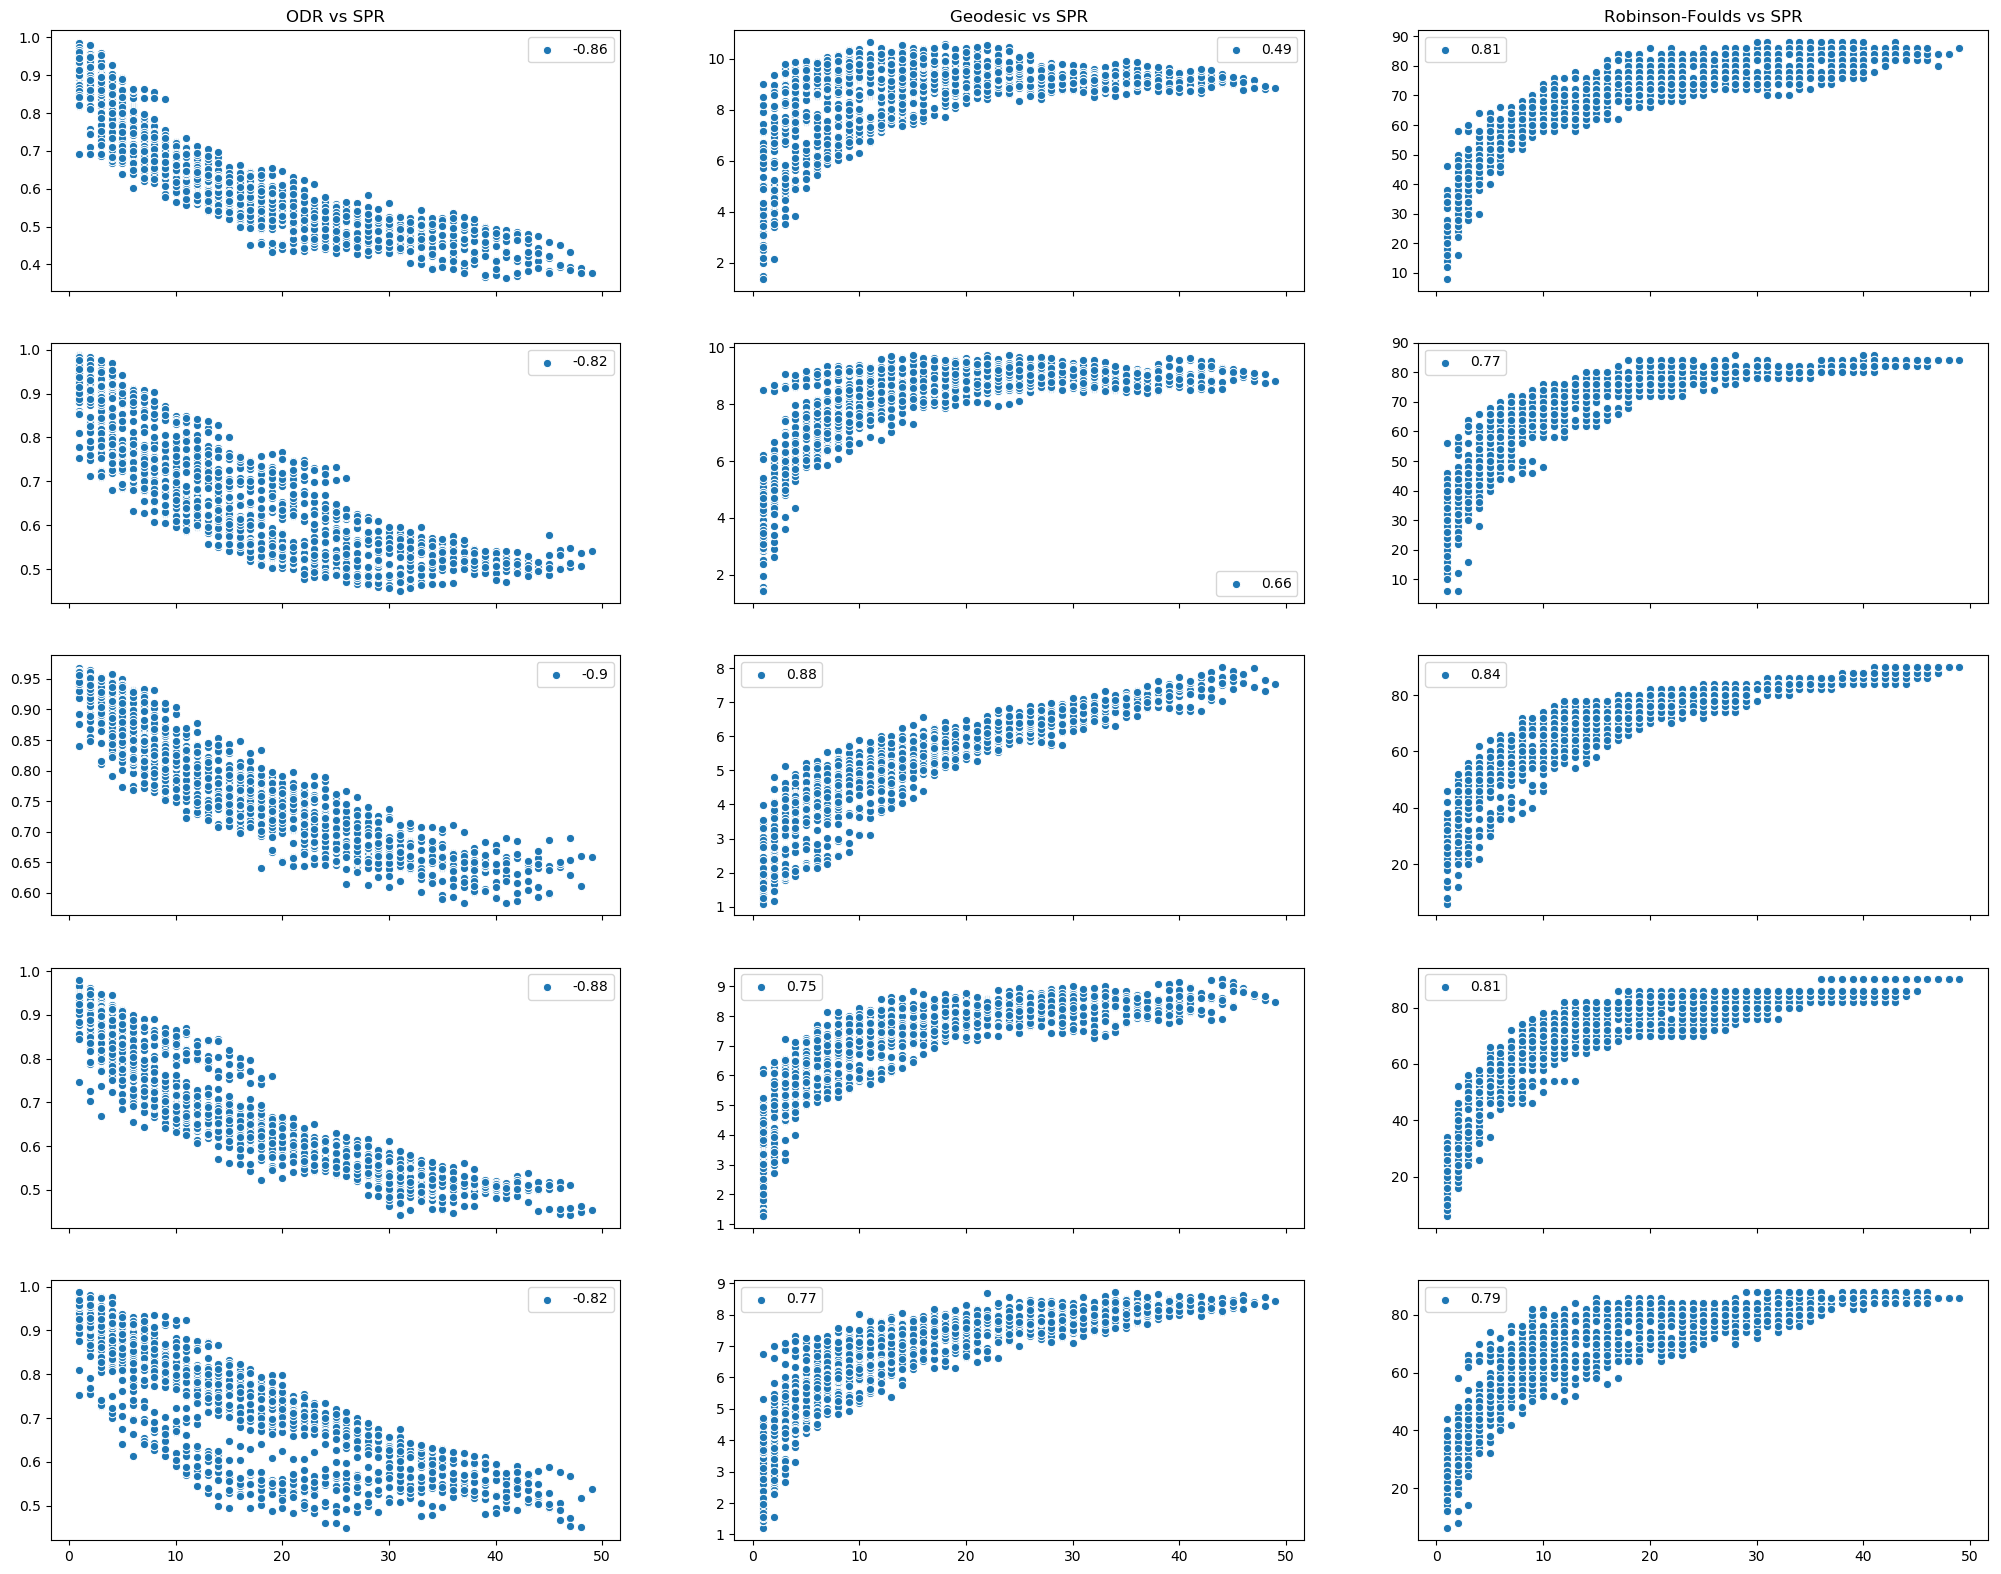

In [65]:
fig, axs = plt.subplots(nrows=5, ncols=3, sharex=True, dpi=100, figsize=(25, 20))

for ax, dataset_num in zip(axs[:, 0], range(1, 11)):
    sns.scatterplot(condensed_spr_distances,
                    datasets[f'set{dataset_num}']['r2'],
                    ax=ax,
#                     alpha=0.5,
                    label=round(pearsonr(condensed_spr_distances, 
                                         datasets[f'set{dataset_num}']['r2'])[0],
                                2))

# for ax, dataset_num in zip(axs[:, 1], range(1, 11)):
#     sns.scatterplot(condensed_spr_distances,
#                     datasets[f'set{dataset_num}']['mse'],
#                     ax=ax,
# #                     alpha=0.5,
#                     label=round(pearsonr(condensed_spr_distances, 
#                                          datasets[f'set{dataset_num}']['mse'])[0],
#                                 2))
    
for ax, dataset_num in zip(axs[:, 1], range(1, 11)):
    sns.scatterplot(condensed_spr_distances,
                    datasets[f'set{dataset_num}']['geodesic'],
                    ax=ax,
#                     alpha=0.5,
                    label=round(pearsonr(condensed_spr_distances, 
                                         datasets[f'set{dataset_num}']['geodesic'])[0],
                                2))
    
for ax, dataset_num in zip(axs[:, 2], range(1, 11)):
    sns.scatterplot(condensed_spr_distances,
                    datasets[f'set{dataset_num}']['rf'],
                    ax=ax,
#                     alpha=0.5,
                    label=round(pearsonr(condensed_spr_distances, 
                                         datasets[f'set{dataset_num}']['rf'])[0],
                                2))

axs[0, 0].set_title('ODR vs SPR');
# axs[0, 1].set_title('MSE vs SPR');
axs[0, 1].set_title('Geodesic vs SPR');
axs[0, 2].set_title('Robinson-Foulds vs SPR');

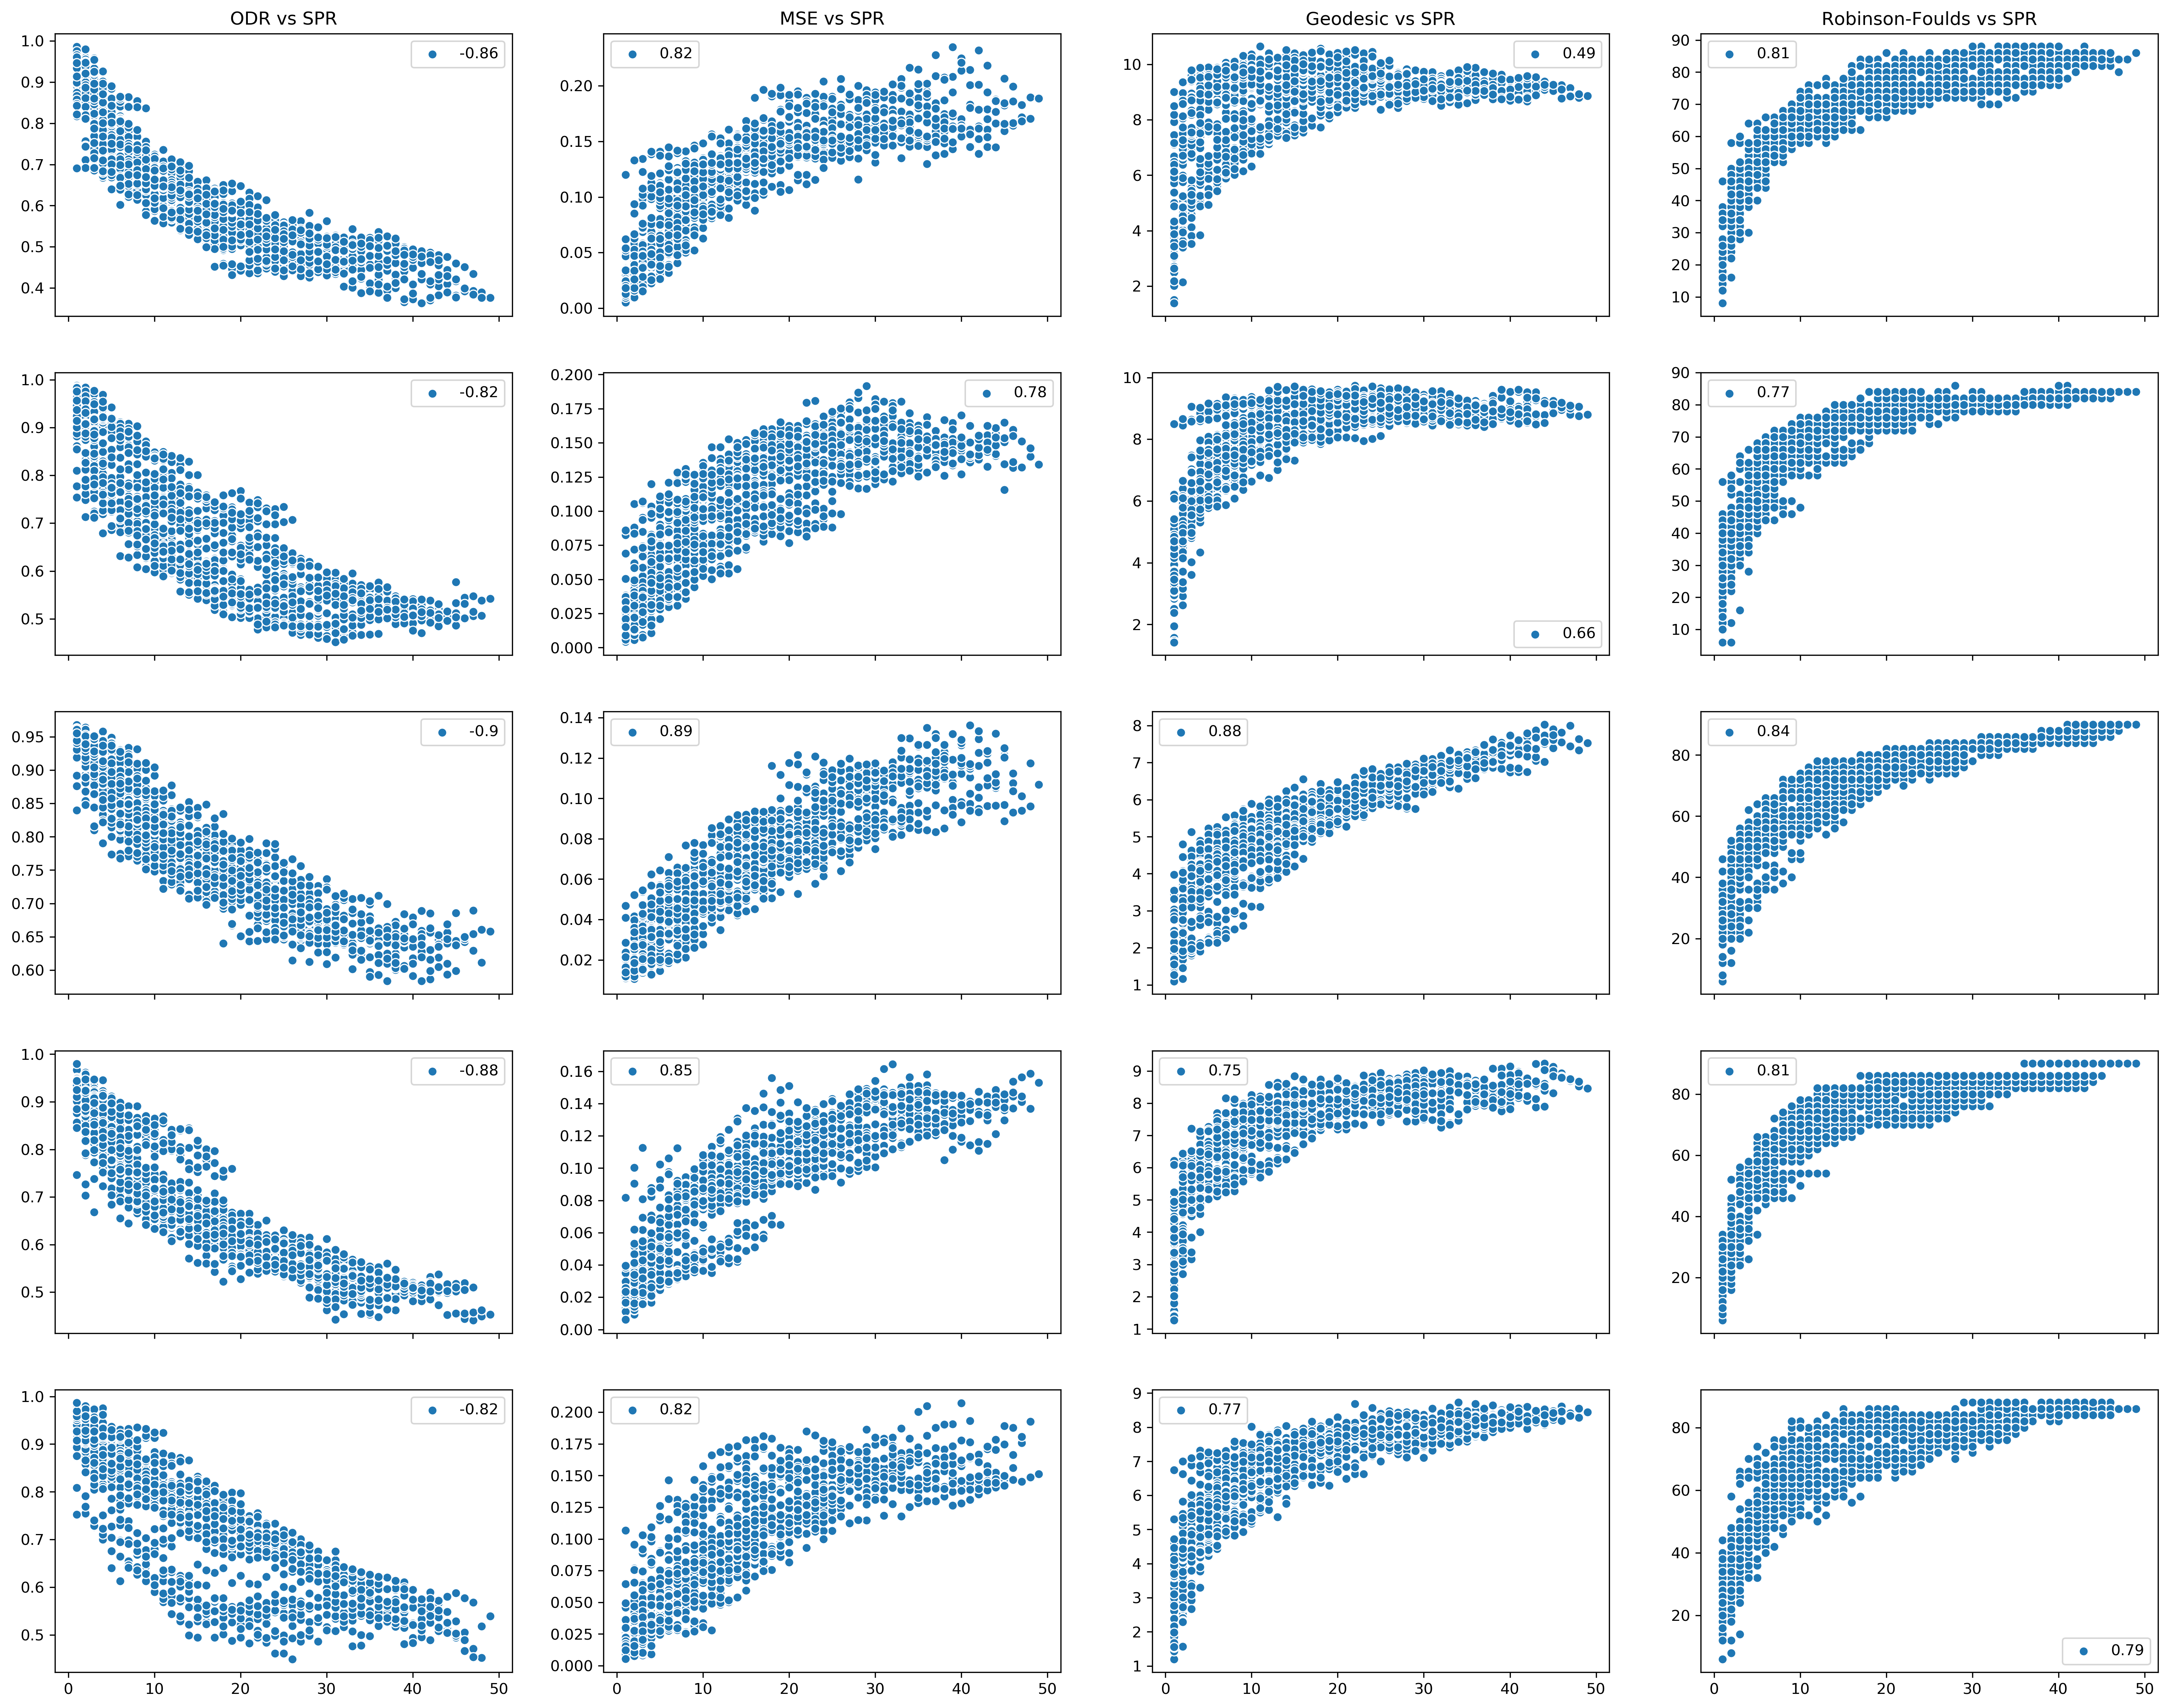

In [32]:
fig, axs = plt.subplots(nrows=5, ncols=4, sharex=True, dpi=300, figsize=(25, 20))

for ax, dataset_num in zip(axs[:, 0], range(1, 11)):
    sns.scatterplot(condensed_spr_distances,
                    datasets[f'set{dataset_num}']['r2'],
                    ax=ax,
#                     alpha=0.5,
                    label=round(pearsonr(condensed_spr_distances, 
                                         datasets[f'set{dataset_num}']['r2'])[0],
                                2))

for ax, dataset_num in zip(axs[:, 1], range(1, 11)):
    sns.scatterplot(condensed_spr_distances,
                    datasets[f'set{dataset_num}']['mse'],
                    ax=ax,
#                     alpha=0.5,
                    label=round(pearsonr(condensed_spr_distances, 
                                         datasets[f'set{dataset_num}']['mse'])[0],
                                2))
    
for ax, dataset_num in zip(axs[:, 2], range(1, 11)):
    sns.scatterplot(condensed_spr_distances,
                    datasets[f'set{dataset_num}']['geodesic'],
                    ax=ax,
#                     alpha=0.5,
                    label=round(pearsonr(condensed_spr_distances, 
                                         datasets[f'set{dataset_num}']['geodesic'])[0],
                                2))
    
for ax, dataset_num in zip(axs[:, 3], range(1, 11)):
    sns.scatterplot(condensed_spr_distances,
                    datasets[f'set{dataset_num}']['rf'],
                    ax=ax,
#                     alpha=0.5,
                    label=round(pearsonr(condensed_spr_distances, 
                                         datasets[f'set{dataset_num}']['rf'])[0],
                                2))

axs[0, 0].set_title('ODR vs SPR');
axs[0, 1].set_title('MSE vs SPR');
axs[0, 2].set_title('Geodesic vs SPR');
axs[0, 3].set_title('Robinson-Foulds vs SPR');